In [ ]:
#This code cell implements the UKF
!pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=673d06615c01c3685aa68b717b78b3258febc2e1bb81c5b31305e0aa7cf25f26
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter
from math import atan2, sin, cos
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import statistics
import numpy as np
from scipy.integrate import odeint
from numpy.typing import DTypeLike

#Kalman filter class
#Contains the necessary operations for implementing kalman filtering
# offsets of each variable in the state vector
class KF:
    def __init__(self, initial_v: float,
                       initial_w: float,
                       torque_left: float, torque_right: float ) -> None:
        # mean of state GRV
        self._x = np.array([[initial_v] , [initial_w]])   # putting velocity and angular velocity in the state space
        self._I = 0.1
        self._l = 1
        self._r = 1
        self._m = 10
        self._G = np.array([[self._I/self._r] , [(self._l*self._m)/self._r]])
        self._F = np.eye(2)
        self._torque_left = torque_left
        self._torque_right = torque_right
        self._ci = self._torque_left + self._torque_right
        #covarianc matrix
        self._P = 10 * np.array([[0.00673794699 , 0], [0 , 0.00247875217]])   # P= 10Q = 10*diag(e^-5,e^-6)


    def predict(self, dt : float, torque_left : float, torque_right : float) -> None:
        # x = F x + G * ci + prediction_noise
        # P = F P Ft + process_covariance

        self._ci = torque_left + torque_right
        prediction_noise = np.array([[0.1] , [0.1]])
        new_x = self._F.dot(self._x) + self._G * (self._ci * dt) + prediction_noise

        #process_covariance_noise is Q matrix Q = diag(e^-5,e^-6)
        process_covariance_noise = np.array([[0.00673794699 , 0], [0 , 0.00247875217]]) #np.matrix([[0.5 , 0.5] , [0.5 , 0.5]]) #
        new_P = self._F.dot(self._P).dot(self._F.T) + process_covariance_noise

        self._P = new_P
        self._x = new_x

    def update(self, meas_velocity: float, meas_angular_velocity: float):
        # y = z - H x
        # S = H P Ht + R
        # K = P Ht S^-1
        # x = x + K y
        # P = (I - K H) * P

        H = np.matrix([[1 , 0] , [0 , 1]])

        z = np.matrix([[meas_velocity], [meas_angular_velocity]])
        R = np.array([[0.13533528323 , 0] ,[0 ,  0.04978706836]])  # R= diag(e^-2,e^-3)

        y = z - H.dot(self._x)
        S = H.dot(self._P).dot(H.T) + R
        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        new_x = self._x + K.dot(y)
        new_P = (np.eye(2) - K.dot(H)).dot(self._P)

        self._P = new_P
        self._x = new_x

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

#This code cell describes the code required for setting up the loop to track velocity and angular velocity values based on robot dynamics
#first let's define initial values for initializing the object for the KF class

def KF_implement(initial_vel = 0, initial_wvel = 0, initial_torque_l = 1.0, initial_torque_r = 1.0):

    initial_v = initial_vel
    initial_w = initial_wvel
    initial_torque_left = initial_torque_l
    initial_torque_right = initial_torque_r
    meas_velocity = initial_vel
    meas_angular_velocity = initial_wvel
    #Defining the kf object
    kf = KF( initial_v , initial_w ,  initial_torque_left , initial_torque_right )
    meas_variance_v = 0.13533528323
    meas_variance_w = 0.04978706836
    DT = 0.1 # time step
    #Initial values of v_reference and w_reference to track
    v_reference = 0#4 * time
    w_reference = 0#5 * time
    #Values drawn from the paper
    C_4 = 5
    C_5 = 5
    c = 1 #Dont know the value
    #robot parameters
    I = 0.1
    l = 1
    r = 1
    m = 10
    #Initializing lists for storing data
    err_v = []
    err_w = []

    V = []
    W = []

    V_m = []
    W_m = []

    V_ref = []
    W_ref = []

    t_l = []
    t_r = []
    t=0
    #Running for thousand steps as the UKF requires a lot of observation points
    NUM_STEPS = 1000
    count = 0
    for step in range(NUM_STEPS):

        kf.predict(DT , initial_torque_left , initial_torque_right)
        ci = initial_torque_left + initial_torque_right
        meas_velocity = meas_velocity + ((I/r)*ci*DT)
        meas_angular_velocity = meas_angular_velocity + (((l * m)/r)*ci*DT)
        noise_1 = np.random.randn() * np.sqrt(meas_variance_v)
        noise_2 = np.random.randn() * np.sqrt(meas_variance_w)
        meas_velocity = meas_velocity +  noise_1
        meas_angular_velocity = 0.1*meas_angular_velocity + noise_2
        if (step != 0 and step % 1 == 0) :
            #carry out the measurement update at each step
            kf.update(meas_velocity , meas_angular_velocity)
        mean = np.array(kf.mean)
        velocity = mean[0][0]
        angular_velocity = 0.03*mean[1][0]
        #According to the equation below we track angular velocity
        w_reference =0*DT
        w_dt = 0
        #Update the time step
        t=t+DT
        #According to the equation below we track linear velocity
        v_reference += 5*DT #1*np.sin(2 * np.pi * t)
        v_dt = 5 # 1*2*np.pi*np.cos(2 * np.pi * t)
        error_velocity = v_reference - velocity
        error_angular = w_reference - angular_velocity
        # We put the required values in the torque control equation
        torque_left  = (((m * r)/2) * (v_dt + C_4 * error_velocity)) - (((I*r)/(2*c)) * (w_dt + C_5 * error_angular))
        torque_right = (((m * r)/2) * (v_dt + C_4 * error_velocity)) + (((I*r)/(2*c)) * (w_dt + C_5 * error_angular))
        initial_torque_left = torque_left
        initial_torque_right = torque_right
        #Append the required values in their respective lists
        err_v.append(error_velocity)
        err_w.append(error_angular)
        V.append(velocity)
        W.append(angular_velocity)
        V_ref.append(v_reference)
        W_ref.append(w_reference)
        # t_l.append(torque_left)
        # t_r.append(torque_right)
        V_m.append(meas_velocity)
        W_m.append(meas_angular_velocity)


    err_v = np.array(err_v)
    err_w = np.array(err_w)
    print("Avg V error:", np.mean(err_v))
    print("Avg W error:", np.mean(err_w))
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(V,label="V kf predict")
    plt.plot(V_m,label="Vmeasured")
    plt.plot(V_ref,label="Vreference")
    plt.legend(loc="upper left")

    plt.title("KF Output on V"+", Avg V error:" + str(np.round(np.mean(err_v),2)))
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")

    plt.subplot(1,2,2)
    plt.plot(W,label="W kf predict")
    plt.plot(W_m,label="Wmeasured")
    plt.plot(W_ref,label="Wreference")
    plt.legend(loc="lower right")
    plt.title("KF Output on W"+", Avg W error:" + str(np.round(np.mean(err_w),2)))
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.show()

    return V_m, W_m
def extract_x_y_theta_dot(V , W):
    x_dot_list = []
    y_dot_list = []
    theta_dot_list = []
    init_theta = 0
    dt = 0.1
    for i in range(len(V)):
        x_dot = np.cos(init_theta) * V[i]
        x_dot_list.append(x_dot)
        y_dot = np.sin(init_theta) * V[i]  # Corrected to sin
        y_dot_list.append(y_dot)
        theta_dot = W[i]
        theta_dot_list.append(theta_dot)
        init_theta = (init_theta + theta_dot * dt) % (2 * np.pi)
    return x_dot_list , y_dot_list , theta_dot_list

def get_F_results_measured(x_list , y_list , theta_list):
    F_results_measured = []
    x = np.array([[0], [0], [0]])
    # Adding Gaussian noise
    x_dot_list = np.random.normal(x_list, 0.5)
    y_dot_list = np.random.normal(y_list, 0.5)
    theta_dot_list = np.random.normal(theta_list, 0.5)
    for i in range(len(x_dot_list)):
        F = np.matrix([[1, 0, 0],
                       [0, 1, 0],
                       [0, 0, 1]], dtype=float)
        Result = np.dot(F, x)
        M = np.matrix([[x_dot_list[i]],
                       [y_dot_list[i]],
                       [theta_dot_list[i]]])
        dt = 0.1
        M_ = M * dt
        F_result = Result + M_
        # Extract the theta value from F_result and adjust it to fit within 0 to 2π radians
        new_theta = F_result[2, 0] % (2 * np.pi)
        F_result[2, 0] = new_theta
        # Append each F_result (reshaped to 1x3) to F_results
        F_results_measured.append(list(np.array(F_result).flatten()))
    print("F_results_measured")#,F_results_measured)
    return F_results_measured

def get_F_results_original(x_list , y_list , theta_list):
  # # Initializing lists to store the computed F_results
  F_results_org = []

  x = np.array([[0], [0], [0]])

  #Here we dont add noise to the x_dot_list, y_dot_list and theta_dot_list because the data here has to act like real data for error computation

  for i in range(len(x_list)):
      F = np.matrix([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]], dtype=float)
      Result = np.dot(F, x)

      M = np.matrix([[x_list[i]],
                    [y_list[i]],
                    [theta_list[i]]])

      dt = 0.1
      M_ = M * dt
      F_result = Result + M_

      # Extract the theta value from F_result and adjust it to fit within 0 to 2π radians
      new_theta = F_result[2, 0] % (2 * np.pi)
      F_result[2, 0] = new_theta

      # Append each F_result (reshaped to 1x3) to F_results
      F_results_org.append(list(np.array(F_result).flatten()))

  # Print the list of F_results
  # plt.plot(F_results_org)
  print("F_results_original")#,F_results_org)
  return(F_results_org)

class DataContainer:
    def __init__(self, x_dot_list, y_dot_list, theta_dot_list):
        self.x_dot_list = x_dot_list
        self.y_dot_list = y_dot_list
        self.theta_dot_list = theta_dot_list
        self.counter = 0

    def get_values(self):
        x = self.x_dot_list[self.counter]
        y = self.y_dot_list[self.counter]
        theta = self.theta_dot_list[self.counter]
        self.counter += 1
        return x, y, theta


#Below are the necssary functions and values required to implement the UKF through the UnscentedKalmanFilter class of the filterpy module
def fx(x, dt):
        x_dot, y_dot, theta_dot = data_container.get_values()
        x = x.reshape(-1, 1)
        F = np.matrix([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]], dtype=float)
        Result = np.dot(F, x)

        M = np.matrix([[x_dot],
                    [y_dot],
                    [theta_dot]])

        M_ = M * dt
        F_result = Result + M_

        # Extract the theta value from F_result and adjust it to fit within 0 to 2π radians
        new_theta = F_result[2, 0] % (2 * np.pi)
        F_result[2, 0] = new_theta
        F_result = F_result.A1.tolist()
        return F_result

def hx (x) :
    return np.array([x[0] , x[1] , x[2]])

def x_mean_fn(sigmas, Wm):
    x = np.zeros(3)
    sum_sin, sum_cos = 0., 0.
    for i in range(len(sigmas)):
        s = sigmas[i]
        x[0] += s[0] * Wm[i]  # Accumulate the weighted x-coordinate
        x[1] += s[1] * Wm[i]  # Accumulate the weighted y-coordinate
        sum_sin += sin(s[2]) * Wm[i]  # Accumulate the weighted sin(theta)
        sum_cos += cos(s[2]) * Wm[i]  # Accumulate the weighted cos(theta)

    # Calculate the overall orientation (theta)
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean_fn(sigmas, Wm):
    z = np.zeros(3)  # Assuming state space: x, y, theta
    sum_sin, sum_cos = 0.0, 0.0

    for i in range(len(sigmas)):
        s = sigmas[i]
        z[0] += s[0] * Wm[i]  # Accumulate the weighted x-coordinate
        z[1] += s[1] * Wm[i]  # Accumulate the weighted y-coordinate
        sum_sin += sin(s[2]) * Wm[i]
        sum_cos += cos(s[2]) * Wm[i]

    z[2] = atan2(sum_sin, sum_cos)  # Calculate the weighted mean orientation
    return z

def residual_x(x, y):
    # x and y are both state vectors [x, y, theta]
    residual = np.array([x[0] - y[0], x[1] - y[1], np.arctan2(np.sin(x[2] - y[2]), np.cos(x[2] - y[2]))])
    angle = np.arctan2(np.sin(x[2] - y[2]), np.cos(x[2] - y[2]))
    if angle < 0:
        angle = angle + (2*np.pi)
    residual[2] = angle
    #print('residual_x')
    #print(residual_x)
    return residual

def residual_z(x, y):
    # x and y are state and measurement vectors [x, y, theta]
    residual = np.array([x[0] - y[0], x[1] - y[1], np.arctan2(np.sin(x[2] - y[2]), np.cos(x[2] - y[2]))])
    angle = np.arctan2(np.sin(x[2] - y[2]), np.cos(x[2] - y[2]))
    if angle < 0:
        angle = angle + (2*np.pi)
    residual[2] = angle
    #print('residual_z')
    #print(residual_z)
    return residual


def generate_state_list(F_results_meas,F_results_org):

    dt = 0.1
    points = MerweScaledSigmaPoints(3, alpha=0.1, beta=2.0, kappa=-1)
    Wm = [-148.99999999999986] + [24.99999999999998] * 6

    kf = UnscentedKalmanFilter(dim_x=3, dim_z=3, dt=dt, fx=fx, hx=hx, points=points, sqrt_fn=None , x_mean_fn=x_mean_fn , z_mean_fn=z_mean_fn , residual_x=residual_x, residual_z=residual_z)
    kf.x = np.array(F_results_meas[0])
    kf.P*= 0.2
    z_std = 0.8
    kf.R = np.diag([z_std**2, z_std**2, z_std**2]) # 1 standard
    kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.8**2, block_size=1)
    state_lst = []
    x_pos_error_list = []
    y_pos_error_list = []
    theta_error_list = []

    for i in range (100) :
        measurement = F_results_meas[i]
        kf.predict()
        kf.update(measurement)
        state_lst.append(list(kf.x))

        original = F_results_org[i]
        # Store the necessary values
        x_pos_error = kf.x[0] - original[0]
        x_pos_error_list.append(x_pos_error)
        y_pos_error = kf.x[1] - original[1]
        y_pos_error_list.append(y_pos_error)
        theta_error = kf.x[2] - original[2]
        theta_error_list.append(theta_error)
    # Compute average errors and print
    average_pos_x_error = statistics.mean(x_pos_error_list)
    average_pos_y_error = statistics.mean(y_pos_error_list)
    average_theta_error = statistics.mean(theta_error_list)
    print("Average Error in Posture(X,Y,Theta)")
    print(average_pos_x_error ,average_pos_y_error , average_theta_error )
    #Plot the error graphs

    plt.subplots(1)
    plt.title("Avg Error in X:"+str(np.round(average_pos_x_error,4)))
    plt.plot(x_pos_error_list,label="x pos error")
    plt.subplots(1)
    plt.title("Avg Error in Y:"+str(np.round(average_pos_y_error,4)))
    plt.plot(y_pos_error_list, label ="y pos error")
    plt.subplots(1)
    plt.title("Avg Error in Theta:"+str(np.round(average_theta_error,4)))
    plt.plot(theta_error_list , label = "theta error")
    plt.show()
    print("State List\n")
    print(state_lst)

    return state_lst

Avg V error: -0.022503763099219184
Avg W error: -6.005633511419816


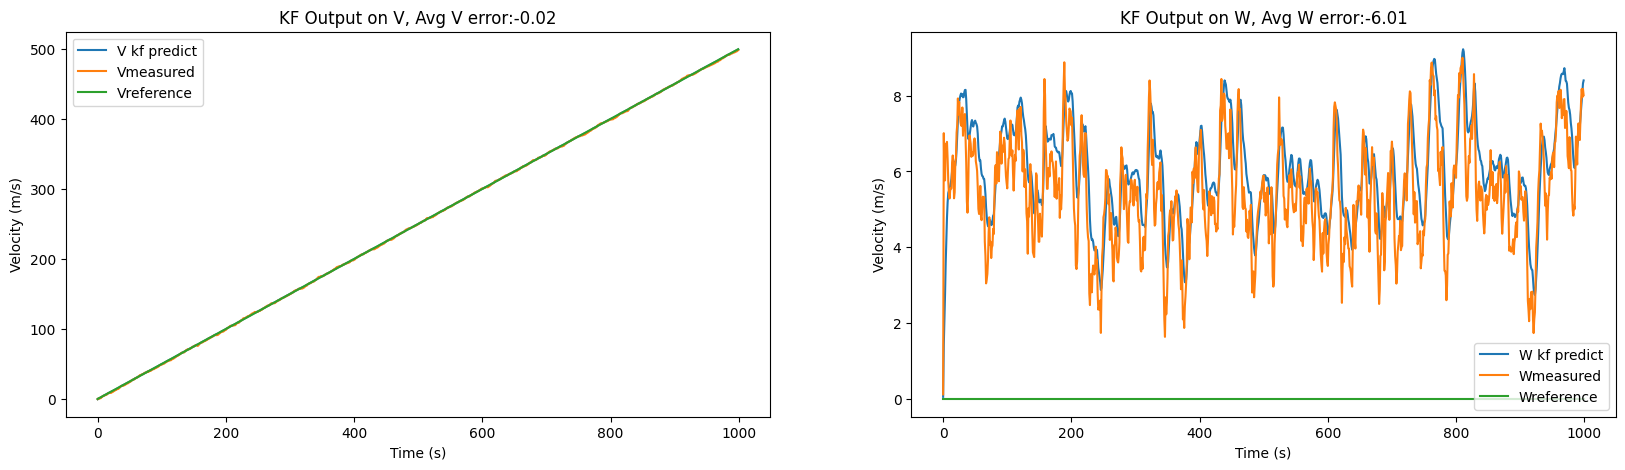

F_results_measured
F_results_original
Average Error in Posture(X,Y,Theta)
-0.00489997470568521 -0.002105637263302365 2.9733555476617246


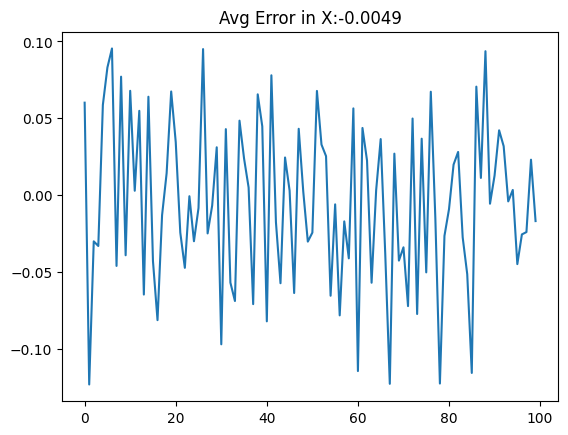

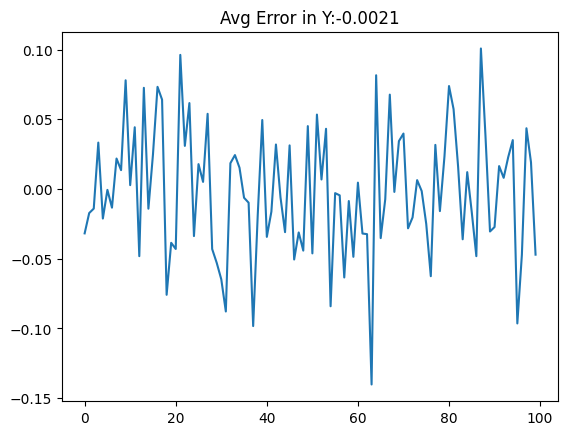

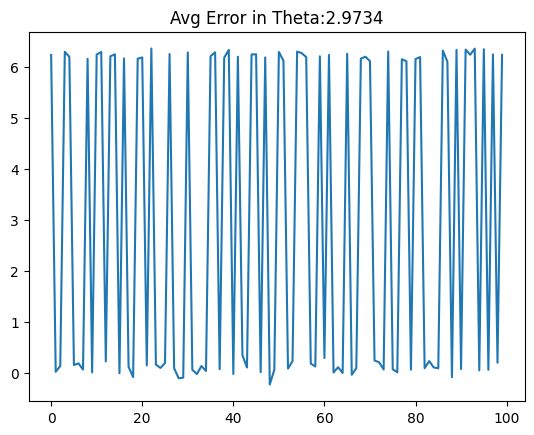

State List

[[0.09141726006289552, -0.031807116872643704, 6.24667475057953], [0.00046632303178739676, -0.01566533324439945, 0.7216903021137435], [0.045572579374947964, 0.051361598146712595, 0.7169147416564482], [-0.00881479431532739, 0.11988954936477114, 6.87177546211855], [-0.0013496103556960293, 0.17006627364730775, 6.869617593096083], [-0.0640992732615473, 0.0986550046032324, 0.7994435952182213], [-0.19503417705635684, -0.029010589501524464, 0.8625412236634338], [-0.3105374224287516, -0.2157064558062416, 0.6969052609052107], [-0.01580890428431303, -0.43105135934143846, 6.733684015111919], [0.1399242939017995, -0.38522316987177874, 0.5519885759833653], [0.45870617564037275, -0.2988474904274767, 6.771667115844429], [0.5670909936603721, -0.02864320810300569, 6.841777740115843], [0.6003465373665904, 0.19619472220006173, 0.7797460266775238], [0.2819523454573982, 0.5859292140829666, 6.762411619400323], [0.08911901881708673, 0.6417562085367194, 6.871780287495931], [-0.46539827550525104, 0.

In [ ]:
V_meas, W_meas = KF_implement()
x_dot_list , y_dot_list , theta_dot_list = extract_x_y_theta_dot(V_meas , W_meas*100)
F_results_measured = get_F_results_measured(x_dot_list , y_dot_list , theta_dot_list)
F_results_original = get_F_results_original(x_dot_list , y_dot_list , theta_dot_list)
data_container = DataContainer(x_dot_list, y_dot_list, theta_dot_list)
state_list = generate_state_list(F_results_measured,F_results_original)

In [ ]:
#Now we start the implementation of bioinspired backsteppig control
#First we generate a path to be tracked
def generate_ref_path():
    x_pos = 4
    y_pos = 4
    theta_pos = 0
    dt = 0.1
    lin_vel = 0.5
    angular_vel = 0
    output_path = []
    x_list = [x_pos]
    y_list = [y_pos]
    theta_list = [theta_pos]
    for i in range(100) :
        x_dot = np.cos(theta_pos) * lin_vel
        x_pos = x_pos + x_dot * dt
        x_list.append(x_pos)
        y_dot = np.sin(theta_pos) * lin_vel
        y_pos = y_pos + y_dot * dt
        y_list.append(y_pos)
        theta_dot = angular_vel
        theta_pos = (theta_pos + theta_dot * dt) % (2 * np.pi)
        theta_list.append(theta_pos)
        value = [x_pos , y_pos , theta_pos]
        output_path.append(value)
    print("Path generated\n")
    print(output_path)
    return output_path


#BACKSTEPPING CONTROLLER
#state_list
#output
# we will compute an error list now
def generate_vr_wr_list(state_list1 , output1):
    error = []
    #Compute the error in the path to be tracked and the path that we recieve through the UKF
    for state, out in zip(state_list1, output1):
        sub = [o - s for o, s in zip(out, state)]
        sub[2] %= 2 * np.pi
        error.append(sub)

    # after computing error values we compute errors ed, el , etheta by mapping to the inertial frame by the following equations
    err_inertial = []
    for e , st in zip(error , state_list1) :
        ed = np.cos(st[2]) * e[0] + np.sin(st[2]) * e[1]
        el = -np.sin(st[2]) * e[0] + np.cos(st[2]) * e[1]
        etheta = e[2]
        value = [ed , el , etheta]
        err_inertial.append(value)

    #Extract ed values
    ed_list = []
    for err in (err_inertial) :
        ed = err[2]
        ed_list.append(ed)
    ##implementing backstepping controller
    ##calulating vs values
    def model(vs, t, A1, B1, D1, f, g):
        dυs_dt = -A1 * vs + (B1 - vs) * f - (D1 + vs) * g
        return dυs_dt
    vs_0 = 0
    A1 = 5
    B1 = 3
    D1 = 3
    f_values = []
    g_values = []
    vs_values = []
    for err in (ed_list) :
        fed = max(err , 0)
        ged = max(-err , 0)
        f_values.append(fed)
        g_values.append(ged)
    for f_value, g_value in zip(f_values, g_values):
        f = f_value
        g = g_value
        t_final = 0.1
        t = [0, t_final]
        vs = odeint(model, vs_0, t, args=(A1, B1, D1, f, g))[-1]
        vs_values.append(vs)
    ##calculating vd values
    vd_values = []
    for val in (output) :
        vd = np.sqrt(val[0] ** 2 + val[1] ** 2)
        vd_values.append(vd)
    ## calculating wd values
    x_values = [sublist[0] for sublist in output1]
    y_values = [sublist[1] for sublist in output1]

    my_list = list(range(1, 101))

    coefficients_1 = np.polyfit(my_list, x_values, 2)
    poly_function_1 = np.poly1d(coefficients_1) # function for xd

    coefficients_2 = np.polyfit(my_list, y_values , 2)
    poly_function_2 = np.poly1d(coefficients_2)  # function for yd

    poly_fun_1_d = poly_function_1.deriv()
    poly_fun_1_d_2 = poly_fun_1_d.deriv()

    poly_fun_2_d = poly_function_2.deriv()
    poly_fun_2_d_2 = poly_fun_2_d.deriv()
    time = 0
    dt = 0.1
    wd_values = []
    for l in range (100) :
        wd = (poly_fun_2_d_2(time) * poly_fun_1_d (time)) - (poly_fun_1_d_2(time) *  poly_fun_2_d (time)) / ((poly_fun_1_d) ** 2 + (poly_fun_2_d ) ** 2)
        time = time + dt
        wd_values.append(wd)
    ##Now to calculate 100 values of vr and wr we use vs, vd, wd , el , etheta  c2 = 5 and c3 = 3
    vr_list = []
    wr_list = []
    for vs, vd, wd, e in zip(vs_values , vd_values , wd_values , err_inertial) :
        el = e[1]
        etheta = e[2]
        vr = vs + vd * np.cos(etheta)
        wr = wd + 5 * vd * el + 3 * vd * np.sin(etheta)
        vr_list.append(vr)
        wr_list.append(wr)

    # print('len of vr_list')
    # print(len(vr_list))
    # print('len of wr_list')
    # print(len(wr_list))
    print("Generated Vr, Wr list")
    # plt.plot(wr_list)

    return vr_list , wr_list

Avg V error: -0.03964380204274772
Avg W error: -5.918957744615602


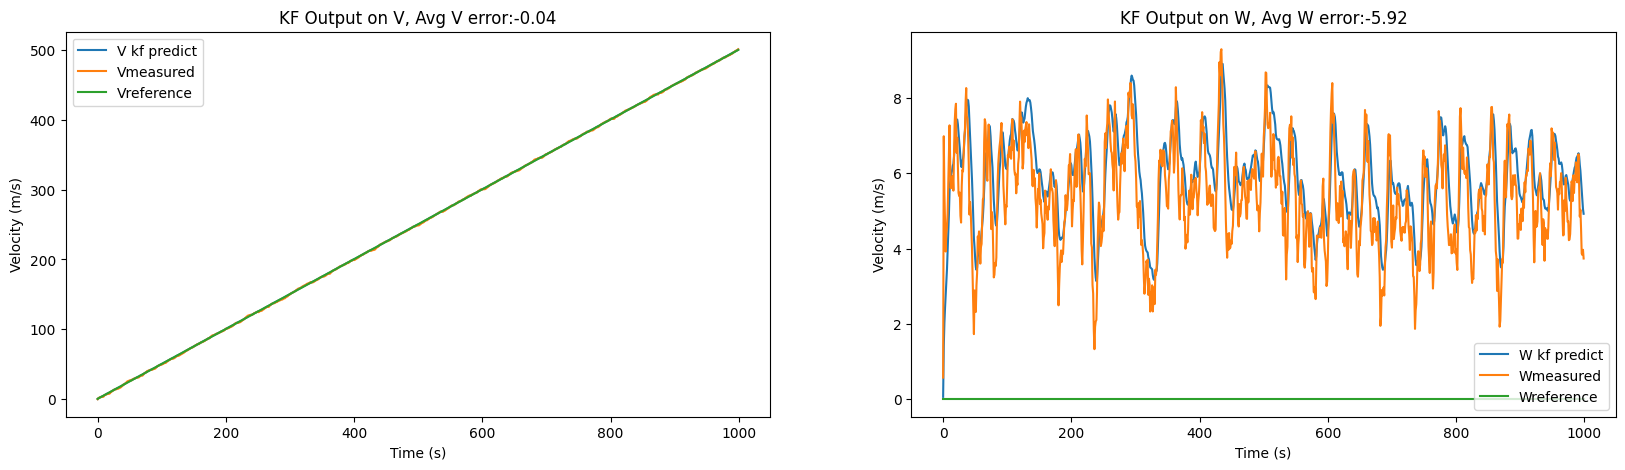

F_results_measured
F_results_original
Average Error in Posture(X,Y,Theta)
-0.004005529170882056 -0.0014723487324834047 3.0818275589820576


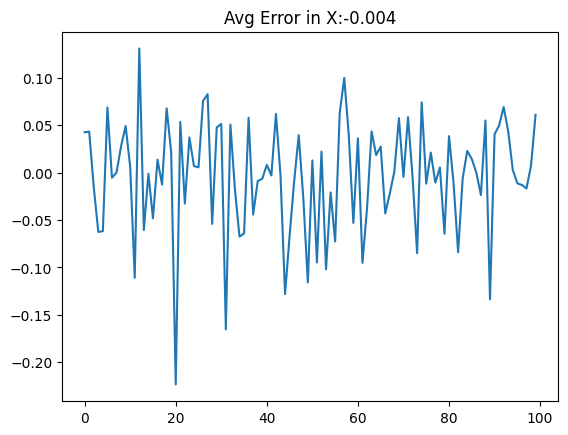

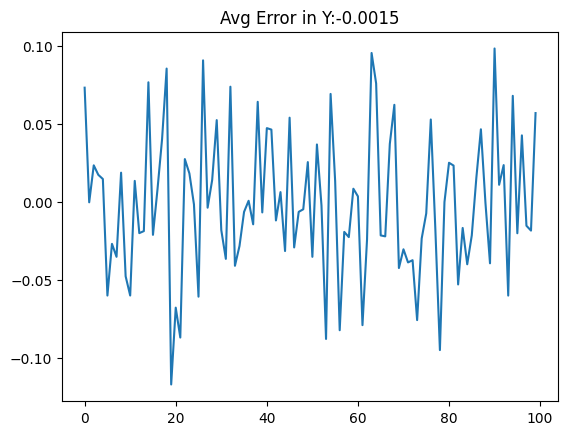

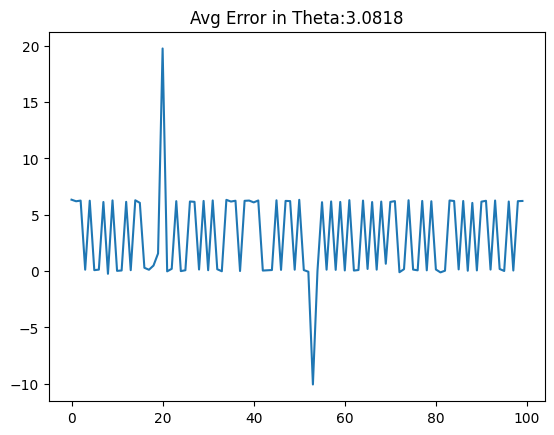

State List

[[0.029676110654359267, 0.07339291466552567, 6.39884499241874], [0.1732365703062584, 0.00725757700076457, 6.900766602905984], [0.12165776186989774, 0.15257132500767057, 6.8061142674923385], [0.00023332491343808215, 0.24523951732774663, 0.5876448047307934], [-0.11560879590871309, 0.28944493245981207, 6.644027017718123], [-0.0910415565230096, 0.1804865452733111, 0.5248442935178814], [-0.25977431539428153, 0.1270405101449228, 0.5881695783065971], [-0.3526738301422938, -0.00447078743138718, 6.631216347171823], [-0.2786236476307522, -0.11325022562971299, 0.33443490594720937], [-0.14318768805903304, -0.3352751255036992, 6.928078823857976], [0.036773616289906386, -0.5748446815109673, 0.7480781211096612], [0.28070154272097625, -0.3767528635833344, 0.68199525609169], [0.73453982944784, -0.11553927772104089, 6.7112938561817845], [0.5330437574535454, 0.2347395775776704, 0.6675145520477046], [0.3710079433537885, 0.6440111977478864, 6.879754707683194], [-0.05542302554511025, 0.729786872

In [ ]:
V_meas, W_meas = KF_implement()
x_dot_list , y_dot_list , theta_dot_list = extract_x_y_theta_dot(V_meas , 100*W_meas)
F_results_measured = get_F_results_measured(x_dot_list , y_dot_list , theta_dot_list)
F_results_original = get_F_results_original(x_dot_list , y_dot_list , theta_dot_list)
data_container = DataContainer(x_dot_list, y_dot_list, theta_dot_list)
state_list = generate_state_list(F_results_measured,F_results_original)
output = generate_ref_path()
vr_list , wr_list = generate_vr_wr_list(state_list , output)

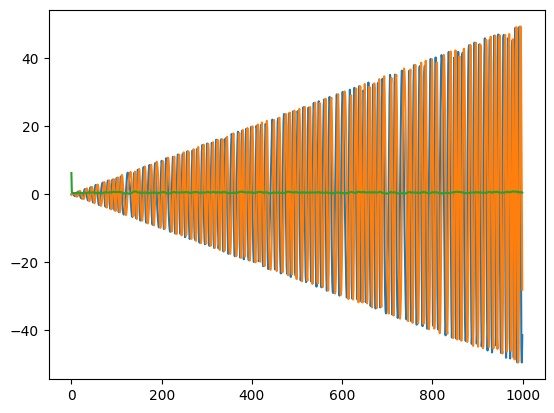

In [ ]:
# # # NOT NEEDEd
# # import numpy as np

# # # Initializing lists to store the computed F_results
# F_results_original = []

# x = np.array([[0], [0], [0]])

# #Here we dont add noise to the x_dot_list, y_dot_list and theta_dot_list because the data here has to act like real data for error computation

# for i in range(len(x_dot_list)):
#     F = np.matrix([[1, 0, 0],
#                    [0, 1, 0],
#                    [0, 0, 1]], dtype=float)
#     Result = np.dot(F, x)

#     M = np.matrix([[x_dot_list[i]],
#                    [y_dot_list[i]],
#                    [theta_dot_list[i]]])

#     dt = 0.1
#     M_ = M * dt
#     F_result = Result + M_

#     # Extract the theta value from F_result and adjust it to fit within 0 to 2π radians
#     new_theta = F_result[2, 0] % (2 * np.pi)
#     F_result[2, 0] = new_theta

#     # Append each F_result (reshaped to 1x3) to F_results
#     F_results_original.append(list(np.array(F_result).flatten()))

# # Print the list of F_results
# plt.plot(F_results_original)


In [ ]:
# #Some calculations for implementing UKF
# # n = 3
# # m = 3
# # kappa = -1
# # alfa = 0.1
# # beta = 2.0
# # lambda_ = (n + kappa) * alfa * alfa - n
# # gamma = np.sqrt(n + lambda_)
# # W0m = lambda_ / (n + lambda_)
# # W0c = lambda_ / (n + lambda_) + (1.0 - alfa * alfa + beta)
# # W = 1.0 / (2.0 * (n + lambda_))

# dt = 0.1
# points = MerweScaledSigmaPoints(3, alpha=0.1, beta=2.0, kappa=-1)
# Wm = [-148.99999999999986] + [24.99999999999998] * 6

# kf = UnscentedKalmanFilter(dim_x=3, dim_z=3, dt=dt, fx=fx, hx=hx, points=points, sqrt_fn=None , x_mean_fn=x_mean_fn , z_mean_fn=z_mean_fn , residual_x=residual_x, residual_z=residual_z)
# kf.x = np.array([0 , 0 , 0])
# kf.P*= 0.2
# z_std = 0.8
# kf.R = np.diag([z_std**2, z_std**2, z_std**2]) # 1 standard
# kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.8**2, block_size=1)
# state_list = []

# # x_pos_error_list = []
# # y_pos_error_list = []
# # theta_error_list = []

# for i in range (100) :
#     measurement = F_results_measured[i]

#     kf.predict()
#     kf.update(measurement)
#     state_list.append(list(kf.x))
#     # original = F_results_original[i]
#     #Store the necessary values
#     # x_pos_error = kf.x[0] - original[0]
#     # x_pos_error_list.append(x_pos_error)
#     # y_pos_error = kf.x[1] - original[1]
#     # y_pos_error_list.append(y_pos_error)
#     # theta_error = kf.x[2] - original[2]
#     # theta_error_list.append(theta_error)
# #Compute average errors and print
# # average_pos_x_error = statistics.mean(x_pos_error_list)
# # average_pos_y_error = statistics.mean(y_pos_error_list)
# # average_theta_error = statistics.mean(theta_error_list)
# # print(average_pos_x_error ,average_pos_y_error , average_theta_error )
# # #Plot the error graphs
# # fig, ax = plt.subplots(3,1)
# # ax[0].plot(x_pos_error_list,label="x pos error")

# # ax[1].plot(y_pos_error_list, label ="y pos error")

# # ax[2].plot(theta_error_list , label = "theta error")
# print(state_list)




[[0.034785310205091236, 0.023746964289314665, 6.247596724177258], [0.12315120775899402, 0.04038029198236792, 1.922471463239121], [-0.057212368173338746, 0.2458806326692553, 5.3447782976631775], [0.03149912052895232, 0.1389251439150314, 8.909192459623402], [-0.053406076858522056, -0.046381693462080875, 7.387213666595315], [-0.006501934428570166, -0.23779497837850272, 6.957921116836198], [0.1968668094143311, -0.14783116488041514, 0.7484757865183209], [0.35310910381173244, -0.023581682853830443, 7.417622991981449], [0.20014890248550188, 0.2803138346431524, 1.3743222831354085], [-0.1697063401855985, 0.07245688106200987, 2.317643280170979], [-0.030626174857900423, -0.4144982137191846, 1.8472098799379038], [0.5786533395612992, -0.011692515392610403, 2.1632279489703103], [-0.389617159464251, 0.4207800544622273, 2.7508661561075516], [0.18090265803684247, -0.5624406613478641, 2.974620044397279], [0.021160384434892876, 0.6421975035221976, 3.114707159658196], [-0.019877759112091553, -0.8692309440